# Isotherm modelling

In this notebook we'll attempt to model isotherms using the included models. First, make sure the data is imported by running the import notebook.

In [1]:
%run import.ipynb
import matplotlib.pyplot as plt

Selected 5 isotherms with nitrogen at 77K
Selected 2 room temperature calorimetry isotherms
Selected 2 isotherms for IAST calculation
Selected 3 isotherms for isosteric enthalpy calculation


## Selecting models

Instead of using the raw creation method for models, we'll use the already available PointIsotherms, together with the `from_pointisotherm` class method. Let's select one of the isotherms and attempt to model it with the Double Site Langmuir model. It is worth noting that, if the branch is not selected, the model will automatically select the adsorption branch.

Attempting to model using DSLangmuir
Model DSLangmuir success, RMSE is 0.339


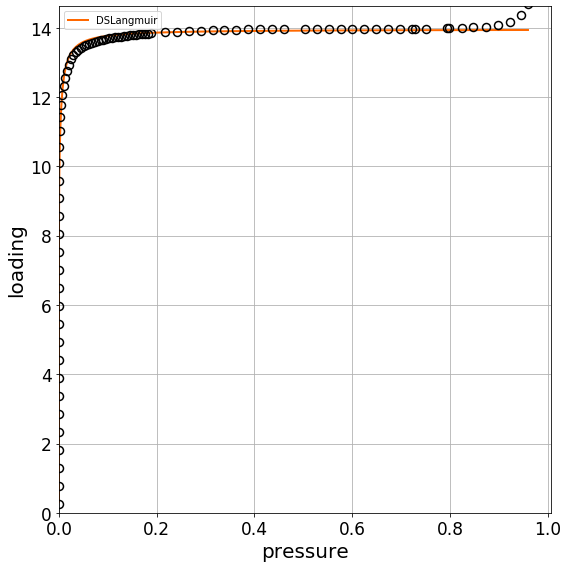

In [2]:
isotherm = next(i for i in isotherms_n2_77k if i.material=='UiO-66(Zr)')
model = pygaps.ModelIsotherm.from_pointisotherm(
    isotherm, model='DSLangmuir', verbose=True)

The original model is therefore reasonably good, even if there are likely microporous filling steps at low pressure which are not represented in the model. It's important to note that the ModelIsotherm has almost all the methods that the PointIsotherm has. For example:

Material: UiO-66(Zr)
Batch: Test
Adsorbate used: nitrogen
Isotherm temperature: 77.355K
iso_type: Isotherme
Units: 
	Unit for loading: mmol/g
	Unit for pressure: bar
Other properties: 
	branch: ads
	is_real: False
	lab: MADIREL
	machine: Triflex
	t_act: 200.0
	user: PI
DSLangmuir isotherm model.
RMSE = 0.3391
Model parameters:
	n_m1 = 4.736341
	K1 = 243.292107
	n_m2 = 9.218453
	K2 = 59122.591502
Model applicable range:
	Pressure range: 0.00 - 0.96
	Loading range: 0.26 - 14.68



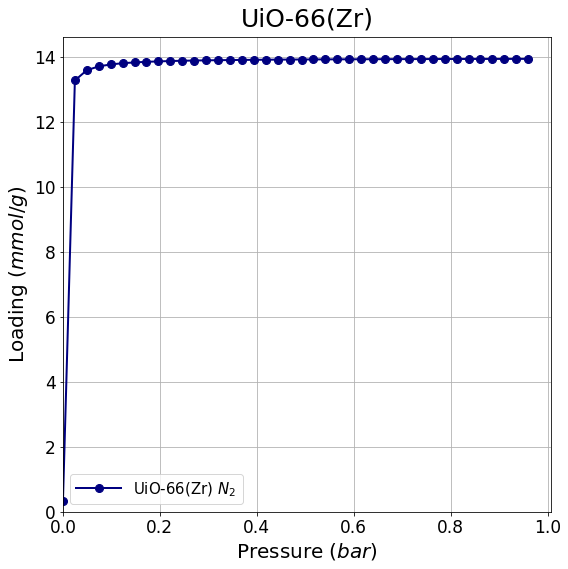

In [3]:
model.print_info(logx=False)

Let's now apply the same model to another isotherm.

In [4]:
isotherm = next(i for i in isotherms_n2_77k if i.material=='SiO2')
try:
    model = pygaps.ModelIsotherm.from_pointisotherm(
        isotherm, model='DSLangmuir', verbose=True)
except Exception as e:
    print(e)

Attempting to model using DSLangmuir

Fitting routine with model DSLangmuir failed with error:
	The maximum number of function evaluations is exceeded.
Try a different starting point in the nonlinear optimization
by passing a dictionary of parameter guesses, param_guess, to the constructor.
Default starting guess for parameters:
{'n_m1': 8.584125, 'K1': 18.630173351237513, 'n_m2': 8.584125, 'K2': 27.94526002685627}



We can increase the number of minimisation iterations manually, by specifying an `optimisation_params` dictionary which will be passed to the relevant Scipy routine. However, the model chosen may not fit the data, no matter how much we attempt to minimise the function, as seen below.

In [5]:
isotherm = next(i for i in isotherms_n2_77k if i.material=='SiO2')
try:
    model = pygaps.ModelIsotherm.from_pointisotherm(
        isotherm, model='DSLangmuir', verbose=True,
        optimization_params=dict(max_nfev=1e4))
except Exception as e:
    print(e)

Attempting to model using DSLangmuir

Fitting routine with model DSLangmuir failed with error:
	The maximum number of function evaluations is exceeded.
Try a different starting point in the nonlinear optimization
by passing a dictionary of parameter guesses, param_guess, to the constructor.
Default starting guess for parameters:
{'n_m1': 8.584125, 'K1': 18.630173351237513, 'n_m2': 8.584125, 'K2': 27.94526002685627}



## Guessing models

We also have the option of guessing a model instead. This option will calculate model fits with a **selection** of the available models, and select the one with the smallest root mean square. Let's try this on the previous isotherm.

Attempting to model using Henry
Model Henry success, RMSE is 1.560
Attempting to model using Langmuir
Modelling using Langmuir failed. Fitting routine outputs:

Fitting routine with model Langmuir failed with error:
	The maximum number of function evaluations is exceeded.
Try a different starting point in the nonlinear optimization
by passing a dictionary of parameter guesses, param_guess, to the constructor.
Default starting guess for parameters:
{'n_m': 17.16825, 'K': 46.575433378093784}

Attempting to model using DSLangmuir
Modelling using DSLangmuir failed. Fitting routine outputs:

Fitting routine with model DSLangmuir failed with error:
	The maximum number of function evaluations is exceeded.
Try a different starting point in the nonlinear optimization
by passing a dictionary of parameter guesses, param_guess, to the constructor.
Default starting guess for parameters:
{'n_m1': 8.584125, 'K1': 18.630173351237513, 'n_m2': 8.584125, 'K2': 27.94526002685627}

Attempting to model usin

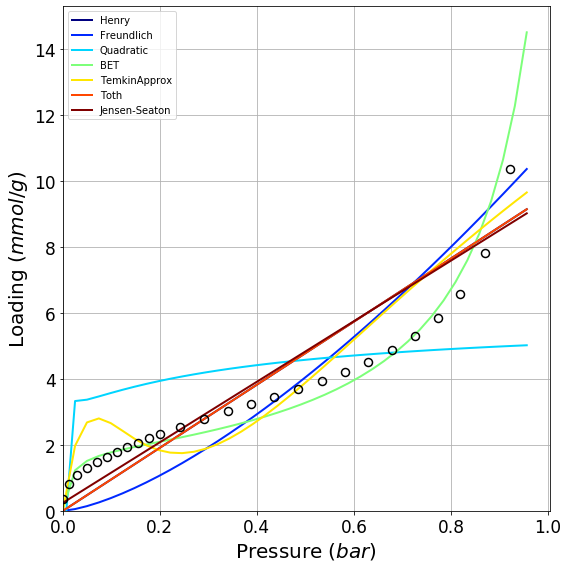

In [6]:
isotherm = next(i for i in isotherms_n2_77k if i.material=='SiO2')

model = pygaps.ModelIsotherm.from_pointisotherm(isotherm, 
                                                guess_model='all', 
                                                verbose=True)

We can see that most models failed or have a poor fit, but the BET model has been correctly identified as the best fitting one.

## Other options

We can also attempt to model the desorption branch of an isotherm, and provide a manual list of models to attempt to guess, including specialised models which are not usually included in the guessing routine.

Attempting to model using GAB
Model GAB success, RMSE is 0.415
Attempting to model using BET
Model BET success, RMSE is 0.415
Attempting to model using Langmuir
Model Langmuir success, RMSE is 0.870
Best model fit is BET


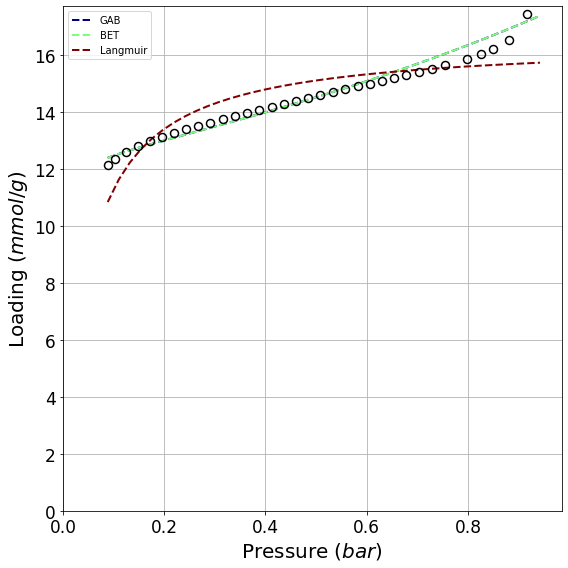

In [7]:
isotherm = next(i for i in isotherms_n2_77k if i.material=='Takeda 5A')

model = pygaps.ModelIsotherm.from_pointisotherm(
    isotherm, guess_model=['GAB', 'BET', 'Langmuir'],
    branch='des', verbose=True)

Just because a the minimisation has successfully produced a model that **does NOT mean** that the model is accurate. For example, trying to model the MCM-41 sample with a Langmuir model does not throw any errors but it is obvious that the model is not representative of the mesoporous condensation in the pores.

Attempting to model using DSLangmuir
Model DSLangmuir success, RMSE is 0.644


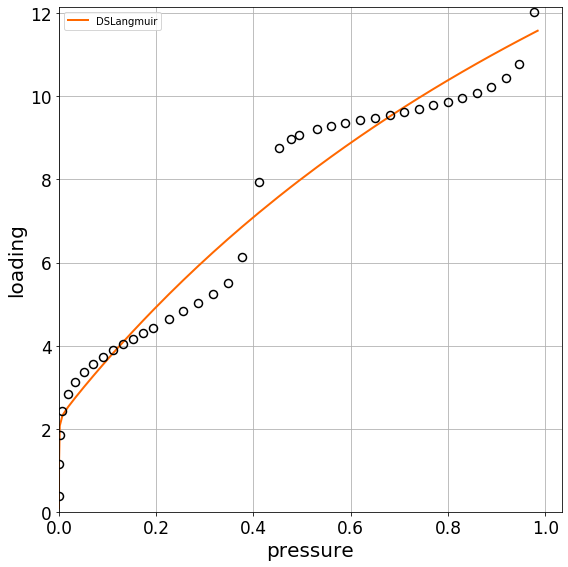

In [8]:
isotherm = next(i for i in isotherms_n2_77k if i.material=='MCM-41')

model = pygaps.ModelIsotherm.from_pointisotherm(isotherm, 
                                                model="DSLangmuir", verbose=True)


More info can be found in the [manual section](https://pygaps.readthedocs.io/en/master/manual/modelling.html).